In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch.quantization as quantization

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
df_train_full = pd.read_csv(train_url, sep='\t')
df_test = pd.read_csv(test_url, sep='\t')
df_train_full.columns = ['sentence', 'label']
df_test.columns = ['sentence', 'label']

df_train_full.shape, df_test.shape

((6919, 2), (1820, 2))

In [3]:
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=42, stratify=df_train_full['label'])

vectorizer = CountVectorizer(max_features=10000, binary=True)
vec_train = vectorizer.fit_transform(df_train['sentence']).toarray()
vec_val = vectorizer.transform(df_val['sentence']).toarray()
vec_test = vectorizer.transform(df_test['sentence']).toarray()

y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

X_train_t = torch.tensor(vec_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(vec_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(vec_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

ds_train = TensorDataset(X_train_t, y_train_t)
ds_val = TensorDataset(X_val_t, y_val_t)
ds_test = TensorDataset(X_test_t, y_test_t)

batch_size = 64
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

X_train_t.shape, X_val_t.shape, X_test_t.shape

(torch.Size([5535, 10000]),
 torch.Size([1384, 10000]),
 torch.Size([1820, 10000]))

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim=10000, out_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.layers(x)


model = MLP(in_dim=vec_train.shape[1], out_dim=2)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {params:}')

Number of parameters: 5293122


In [5]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
best_acc = 0
ckpt_path = 'checkpoint.pt'
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    t_loss = t_ok = t_total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * x.size(0)
        _, pred = torch.max(out.data, 1)
        t_total += y.size(0)
        t_ok += (pred == y).sum().item()
    history['train_loss'].append(t_loss / t_total)
    history['train_acc'].append(t_ok / t_total)

    model.eval()
    v_loss, v_ok, v_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            v_loss += loss.item() * x.size(0)
            _, pred = torch.max(out.data, 1)
            v_total += y.size(0)
            v_ok += (pred == y).sum().item()

    val_acc = v_ok / v_total
    history['val_loss'].append(v_loss / v_total)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), ckpt_path)
        print(f"   -> Best Val Acc: {best_acc:.4f}. Model saved.")

Epoch 1/10 | Train Loss: 0.5964 Acc: 0.6569 | Val Loss: 0.4852 Acc: 0.7681
   -> Best Val Acc: 0.7681. Model saved.
Epoch 2/10 | Train Loss: 0.2496 Acc: 0.9005 | Val Loss: 0.6146 Acc: 0.7710
   -> Best Val Acc: 0.7710. Model saved.
Epoch 3/10 | Train Loss: 0.0702 Acc: 0.9754 | Val Loss: 0.9111 Acc: 0.7695
Epoch 4/10 | Train Loss: 0.0145 Acc: 0.9953 | Val Loss: 1.2623 Acc: 0.7645
Epoch 5/10 | Train Loss: 0.0040 Acc: 0.9986 | Val Loss: 1.7793 Acc: 0.7652
Epoch 6/10 | Train Loss: 0.0047 Acc: 0.9980 | Val Loss: 2.0632 Acc: 0.7464
Epoch 7/10 | Train Loss: 0.0041 Acc: 0.9989 | Val Loss: 1.8563 Acc: 0.7601
Epoch 8/10 | Train Loss: 0.0021 Acc: 0.9993 | Val Loss: 1.9374 Acc: 0.7767
   -> Best Val Acc: 0.7767. Model saved.
Epoch 9/10 | Train Loss: 0.0016 Acc: 0.9993 | Val Loss: 2.0614 Acc: 0.7731
Epoch 10/10 | Train Loss: 0.0009 Acc: 0.9998 | Val Loss: 2.2095 Acc: 0.7710


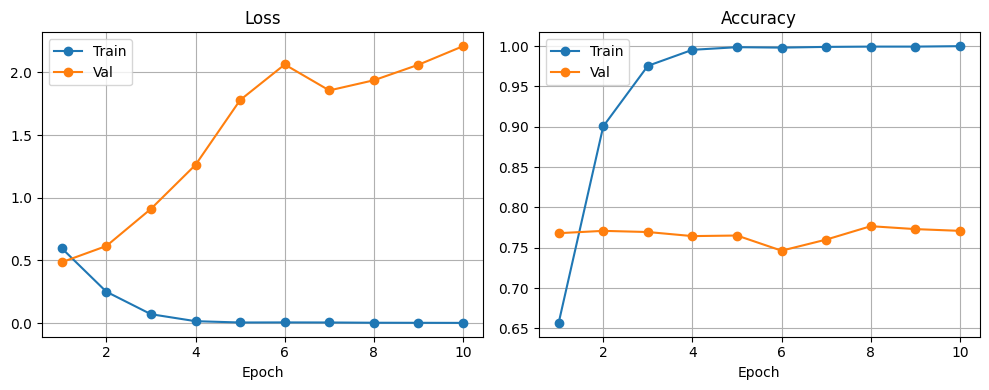

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history['train_loss'], 'o-', label='Train')
plt.plot(range(1, epochs + 1), history['val_loss'], 'o-', label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history['train_acc'], 'o-', label='Train')
plt.plot(range(1, epochs + 1), history['val_acc'], 'o-', label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def test_model(model, loader, device, model_dtype='float'):
    model.eval()
    model.to(device)
    correct, total = 0, 0
    start_time = time.time()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if model_dtype == 'half':
                x = x.half()
            out = model(x)
            if model_dtype == 'half':
                out = out.float()
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    end_time = time.time()
    acc = correct / total
    infer_time_ms = (end_time - start_time) / total * 1000
    return acc, infer_time_ms

In [8]:
def get_size_mb(model, path="temp_size.pt"):
    if isinstance(model, torch.jit.ScriptModule):
        torch.jit.save(model, path)
    else:
        torch.save(model.state_dict(), path)
    size = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return size

In [9]:
results = []
in_features = vec_train.shape[1]
cpu_device = torch.device("cpu")

model_fp32 = MLP(in_dim=in_features)
model_fp32.load_state_dict(torch.load(ckpt_path, map_location=device))
acc_fp32, time_fp32 = test_model(model_fp32, test_loader, device, 'float')
size_fp32 = get_size_mb(model_fp32)
results.append({'Model Name': 'Original FP32', 'Accuracy (%)': acc_fp32 * 100, 'Size (MB)': size_fp32, 'Inference (ms)': time_fp32})

print(f"FP32:")
print(f'Accuracy: {acc_fp32 * 100:.2f}%')
print(f'Size: {size_fp32:.2f}MB')
print(f'Inference Time: {time_fp32:.4f}ms')

FP32:
Accuracy: 78.02%
Size: 20.20MB
Inference Time: 0.0128ms


In [10]:
model_int8_base = MLP(in_dim=in_features)
model_int8_base.load_state_dict(torch.load(ckpt_path, map_location=cpu_device))
model_int8_base.eval()
model_int8 = quantization.quantize_dynamic(model_int8_base, {nn.Linear}, dtype=torch.qint8)
acc_int8, time_int8 = test_model(model_int8, test_loader, cpu_device, 'int8')

size_int8 = get_size_mb(torch.jit.script(model_int8))
results.append({'Model Name': 'Dynamic INT8', 'Accuracy (%)': acc_int8 * 100, 'Size (MB)': size_int8, 'Inference (ms)': time_int8})

print("Dynamic INT8:")
print(f'Accuracy: {acc_int8 * 100:.2f}%')
print(f'Size: {size_int8:.2f}MB')
print(f'Inference Time: {time_int8:.4f}ms')

Dynamic INT8:
Accuracy: 77.97%
Size: 5.07MB
Inference Time: 0.0321ms


In [11]:
model_fp16 = MLP(in_dim=in_features)
model_fp16.load_state_dict(torch.load(ckpt_path, map_location=device))
model_fp16 = model_fp16.half()
model_fp16.eval()
acc_fp16, time_fp16 = test_model(model_fp16, test_loader, device, 'half')
size_fp16 = get_size_mb(model_fp16)
results.append({'Model Name': 'Half FP16', 'Accuracy (%)': acc_fp16 * 100, 'Size (MB)': size_fp16, 'Inference (ms)': time_fp16})

print("FP16:")
print(f'Accuracy: {acc_fp16 * 100:.2f}%')
print(f'Size: {size_fp16:.2f}MB')
print(f'Inference Time: {time_fp16:.4f}ms')

FP16:
Accuracy: 78.02%
Size: 10.10MB
Inference Time: 0.0503ms


In [12]:
df_results = pd.DataFrame(results)

df_results['Accuracy (%)'] = df_results['Accuracy (%)'].map('{:.2f}'.format)
df_results['Size (MB)'] = df_results['Size (MB)'].map('{:.2f}'.format)
df_results['Inference (ms)'] = df_results['Inference (ms)'].map('{:.4f}'.format)

display(df_results)

,Model Name,Accuracy (%),Size (MB),Inference (ms)
0,Original FP32,78.02,20.20,0.0128
1,Dynamic INT8,77.97,5.07,0.0321
2,Half FP16,78.02,10.10,0.0503
